In [21]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
import torch
import numpy as np
# from tqdm.notebook import tqdm  # Use notebook-friendly tqdm
import matplotlib.pyplot as plt
from argparse import Namespace
#from torch_geometric.explain import Explainer, GNNExplainer
import sys
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout


sys.path.append('..')

# from src.explainability.gnn_explainer import GNNExplainer
# from main_transductive import pretrain
from src.utils import set_random_seed #, create_optimizer, WBLogger
from src.datasets.data_util import load_dataset, load_processed_graph
from src.models import build_model, PreModel
# from src.evaluation import node_classification_evaluation
# from src.utils import build_args, load_best_configs  # if needed
from src.explainability.gnn_explainer import GNNExplainer


In [2]:
# ----------------------
# Config settings
# ----------------------
# Choose device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set seed for reproducibility
seed = 0
set_random_seed(seed)

In [3]:
# Define training hyperparameters
dataset_name    = "CPDB_cdgps" 
max_epoch       = 100           # Total training epochs
max_epoch_f     = 200           
num_hidden      = 64
num_layers      = 3
encoder_type    = "rgcn"     
decoder_type    = "rgcn"    
replace_rate    = 0.05
num_edge_types  = 6
in_drop         = 0.2
attn_drop       = 0.1
mask_rate       = 0.5
drop_edge_rate  = 0.0
alpha_l         = 3
num_heads       = 4
activation      = "prelu"          
optimizer       = "adam"            
loss_fn         = "sce"      
lr              = 0.01
weight_decay    = 1e-3
lr_f            = 0.005              
weight_decay_f  = 1e-4
linear_prob     = False
load_model      = False              # Set True to load a checkpoint
save_model      = True              # Set True to save trained model
logs            = True              # Set True to use WBLogger
use_scheduler   = True              # Set True to use a learning rate scheduler
weight_decomposition = {'type': 'basis', 'num_bases': 2}
vertical_stacking = True

In [4]:
# ----------------------
# Create a Namespace for Args
# ----------------------

args = Namespace(
    device         = device,
    seeds          = [seed],
    dataset        = dataset_name,
    max_epoch      = max_epoch,
    max_epoch_f    = max_epoch_f,
    num_hidden     = num_hidden,
    num_layers     = num_layers,
    encoder        = encoder_type,
    decoder        = decoder_type,
    activation     = activation,
    in_drop        = in_drop,
    attn_drop      = attn_drop,
    mask_rate      = mask_rate,
    drop_edge_rate = drop_edge_rate,
    alpha_l        = alpha_l,
    num_heads      = num_heads,
    weight_decomposition = weight_decomposition,
    vertical_stacking = vertical_stacking,
    replace_rate   = replace_rate,
    num_edge_types = num_edge_types,
    optimizer      = optimizer,
    loss_fn        = loss_fn,
    lr             = lr,
    weight_decay   = weight_decay,
    lr_f           = lr_f,
    weight_decay_f = weight_decay_f,
    linear_prob    = linear_prob,
    load_model     = load_model,
    save_model     = save_model,
    logging        = logs,
    scheduler      = use_scheduler,
    num_features   = 6, 
    num_out_heads  = 1,
    residual = False,
    norm = None,
    negative_slope = 0.2,
    concat_hidden = False,
    #return_hidden = False,
)

In [5]:
# ----------------------
# Load Dataset and Build Model
# ----------------------
# Load your graph from file.
graph = load_processed_graph(f'../data/real/multidim_graph/6d/{dataset_name}_multiomics.pt')
num_features = graph.x.shape[1]
num_classes = graph.y.max().item() + 1

args.num_features = num_features  
# (Optionally, you might add: args.num_classes = num_classes)

# Build and move model to device.
model = build_model(args)
model.to(device)

# Load the pretrained embedding (reconstruction) weights.
model.load_state_dict(torch.load('../checkpoints/emb_extraction_model.pt'))


<All keys matched successfully>

In [6]:
# ----------------------
# Reconfigure model for classification (reset head)
# ----------------------
encoder = model.encoder
encoder.reset_classifier(num_classes, concat=True, datas_dim = 0)


In [7]:
print(graph.edge_index.shape)  # Should be: torch.Size([2, E])
print(graph.edge_type.shape)  # Should be: torch.Size([E])

torch.Size([2, 557288])
torch.Size([557288])


### **EGFR**

In [8]:
graph.name[18]

# ----------------------
# Explanation with GNNExplainer (using the classification head)
# ----------------------
node_idx = 18 

# Wrap model with modified GNNExplainer
explainer = GNNExplainer(encoder, epochs=200, lr=0.01, num_hops=2)

# Get explanation masks
node_feat_mask, edge_mask = explainer.explain_node(node_idx, graph)

x_sub shape: torch.Size([10866, 64])
edge_index_sub shape: torch.Size([2, 528344])
mapping: tensor([18])
Out 1: tensor([[-0.0445],
        [-0.0444],
        [-0.0447],
        ...,
        [-0.0445],
        [-0.0446],
        [-0.0445]])
Out after extraction: tensor([[-0.0445],
        [-0.0444],
        [-0.0447],
        ...,
        [-0.0445],
        [-0.0446],
        [-0.0445]])
log_logits shape: torch.Size([10866, 1])
pred_label shape: torch.Size([10866])
Module is Instance of MessagePassing
Module is Instance of MessagePassing
Module is Instance of MessagePassing


/Users/bty416/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/martina/01_PhD/05_Projects/04_Druggable-genes/SMG-DG/notebooks/../src/utils.py:480: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:646.)
  values = torch.sparse.FloatTensor(indices.t(), values, torch.Size(size))
Explain node 18: 100%|██████████| 200/200 [00:38<00:00,  5.26it/s]


In [23]:
K = 20
# full_edge_mask is a length-E Tensor of sigmoid-normalized scores in [0,1]
# get the indices of the top-K edges
topk = torch.topk(edge_mask, K).indices    # shape [K]
# extract their edge endpoints
topk_edges = graph.edge_index[:, topk]               # shape [2, K]

G = nx.Graph()
# add only the K edges
for u, v in topk_edges.t().tolist():
    G.add_edge(int(u), int(v))

# assume G is your graph and node_idx is the “focus” node
# make sure pydot & graphviz (“twopi”) are on your PATH

pos = graphviz_layout(
    G,
    prog='twopi',
    # args=f'-Groot={node_idx}'    # tell twopi which node is the center
)


idx2gene = { i: name for i, name in enumerate(graph.name) }

# offset = 0.04   # tweak this (in the same coordinate space as your layout) until it looks good

# # build a new dict of label positions
# label_pos = { n: (xy[0] - offset, xy[1] + offset)
#               for n, xy in pos.items() }


# -----------------------------------------------------------
# 1) make sure the *explained* node is present in the sub-graph
# -----------------------------------------------------------
if node_idx not in G:
    G.add_node(node_idx)            # add it (isolated) so we can style it
    pos[node_idx] = (0, 0)          # optional: anchor it roughly in the centre

# -----------------------------------------------------------
# 2) build style vectors
# -----------------------------------------------------------
# node sizes / colours
node_sizes  = [3000 if n == node_idx else 100      for n in G.nodes()]
node_colors = ['steelblue' if n == node_idx else 'skyblue' for n in G.nodes()]

# edge widths   (→ contribution weight)
edge_scores = edge_mask[topk].cpu().numpy()
# put them on a convenient 1-to-6 pt scale
edge_widths = 1 + 5 * (edge_scores - edge_scores.min()) / (
                          edge_scores.max() - edge_scores.min() + 1e-9)

# build a lookup so the order of widths matches nx.draw_networkx_edges
edge_w_lookup = {(u, v): w for (u, v), w in zip(topk_edges.t().tolist(),
                                                edge_widths)}
edge_widths_ordered = [edge_w_lookup.get((u, v),
                         edge_w_lookup.get((v, u), 1)) for u, v in G.edges()]

# -----------------------------------------------------------
# 3) draw
# -----------------------------------------------------------
plt.figure(figsize=(8,8))
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       linewidths=0.8,
                       edgecolors='black')

nx.draw_networkx_edges(G, pos,
                       width=edge_widths_ordered,
                       edge_color='black')

nx.draw_networkx_labels(G, label_pos,
                       labels={n: idx2gene[n] for n in G.nodes()},
                       font_size=12,
                       horizontalalignment='left',
                       verticalalignment='center')

plt.title(f"Top {K} most important edges for predicting node {idx2gene[node_idx]}")
plt.axis('off')
plt.tight_layout()
plt.savefig(f"../paper/figures/top_{K}_edges_{idx2gene[node_idx]}.png",
            dpi=300, bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] "twopi" not found in path.

In [25]:
feature_names = ['MF: KIRC', 'MF: BRCA', 'MF: READ', 'MF: PRAD', 'MF: STAD',
       'MF: HNSC', 'MF: LUAD', 'MF: THCA', 'MF: BLCA', 'MF: ESCA',
       'MF: LIHC', 'MF: UCEC', 'MF: COAD', 'MF: LUSC', 'MF: CESC',
       'MF: KIRP', 'METH: KIRC', 'METH: BRCA', 'METH: READ',
       'METH: PRAD', 'METH: STAD', 'METH: HNSC', 'METH: LUAD',
       'METH: THCA', 'METH: BLCA', 'METH: ESCA', 'METH: LIHC',
       'METH: UCEC', 'METH: COAD', 'METH: LUSC', 'METH: CESC',
       'METH: KIRP', 'GE: KIRC', 'GE: BRCA', 'GE: READ', 'GE: PRAD',
       'GE: STAD', 'GE: HNSC', 'GE: LUAD', 'GE: THCA', 'GE: BLCA',
       'GE: ESCA', 'GE: LIHC', 'GE: UCEC', 'GE: COAD', 'GE: LUSC',
       'GE: CESC', 'GE: KIRP', 'CNA: KIRC', 'CNA: BRCA', 'CNA: READ',
       'CNA: PRAD', 'CNA: STAD', 'CNA: HNSC', 'CNA: LUAD',
       'CNA: THCA', 'CNA: BLCA', 'CNA: ESCA', 'CNA: LIHC',
       'CNA: UCEC', 'CNA: COAD', 'CNA: LUSC', 'CNA: CESC',
       'CNA: KIRP']

feat_imp = node_feat_mask.cpu().numpy()
feat_imp = np.squeeze(feat_imp)                     # now shape (F,)

# 2) Sanity check lengths:
assert feat_imp.shape[0] == len(feature_names), (
    f"mask length {feat_imp.shape[0]} vs names {len(feature_names)}"
)

df = pd.DataFrame({
    'feature': feature_names,   # e.g. ['expr', 'meth', 'mut', …]
    'importance': feat_imp
}).sort_values('importance', ascending=False)
print(df.head(20))

       feature  importance
52   CNA: STAD    0.162244
61   CNA: LUSC    0.160579
42    GE: LIHC    0.159693
34    GE: READ    0.153769
22  METH: LUAD    0.153760
32    GE: KIRC    0.153259
10    MF: LIHC    0.151836
0     MF: KIRC    0.151609
51   CNA: PRAD    0.151189
37    GE: HNSC    0.151166
25  METH: ESCA    0.150684
11    MF: UCEC    0.149515
21  METH: HNSC    0.149495
26  METH: LIHC    0.149299
62   CNA: CESC    0.149085
14    MF: CESC    0.148849
30  METH: CESC    0.148537
38    GE: LUAD    0.148054
40    GE: BLCA    0.147098
8     MF: BLCA    0.146741


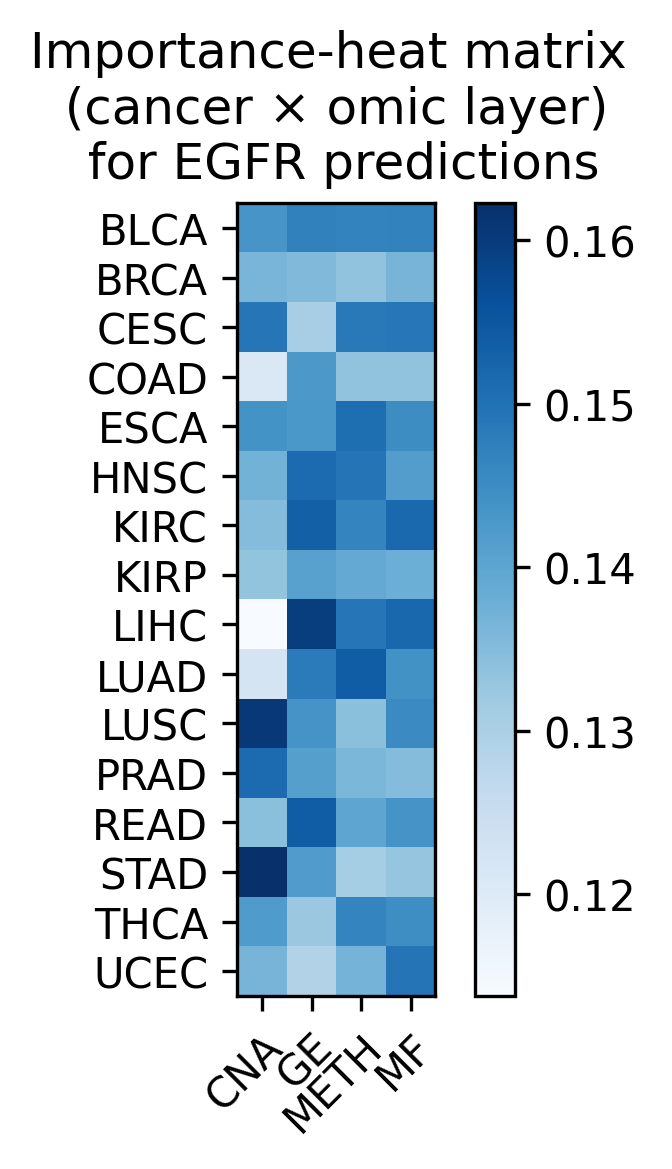

Heat-matrix saved → feature_importance_heatmatrix_EGFR.png


In [26]:
TOP_K        = 20                 # how many bars to keep
DPI          = 300
# Build a wide matrix: rows = cancer type, columns = layer
wide_df = (
    df.assign(
        layer  = df["feature"].str.split(":").str[0].str.strip(),
        cancer = df["feature"].str.split(":").str[1].str.strip()
    )
    .pivot(index="cancer", columns="layer", values="importance")
    .fillna(0)
)

fig2, ax2 = plt.subplots(figsize=(4, 4), dpi=DPI)
im = ax2.imshow(wide_df.values,
                cmap="Blues",
                vmin=df["importance"].min(),
                vmax=df["importance"].max())

ax2.set_xticks(range(len(wide_df.columns)))
ax2.set_yticks(range(len(wide_df.index)))
ax2.set_xticklabels(wide_df.columns)
ax2.set_yticklabels(wide_df.index)

plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize = 10)
ax2.set_title("Importance-heat matrix \n (cancer × omic layer) \n for EGFR predictions",  fontsize = 12)
fig2.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
fig2.tight_layout()
fig2.savefig("../paper/figures/feature_importance_heatmatrix_EGFR.png", dpi=DPI, bbox_inches="tight")
plt.show()
print("Heat-matrix saved → feature_importance_heatmatrix_EGFR.png")

### **NOTCH1**

In [8]:
graph.name[473]
# ----------------------
# Explanation with GNNExplainer (using the classification head)
# ----------------------
node_idx = 473  # The node you want to explain

# Wrap your model with the modified GNNExplainer:
explainer = GNNExplainer(encoder, epochs=200, lr=0.01, num_hops=2)

# Get the explanation masks.
node_feat_mask, edge_mask = explainer.explain_node(node_idx, graph)

/Users/bty416/Library/CloudStorage/OneDrive-QueenMary,UniversityofLondon/martina/01_PhD/05_Projects/04_Druggable-genes/SMG-DG/notebooks/../src/utils.py:480: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:646.)
  values = torch.sparse.FloatTensor(indices.t(), values, torch.Size(size))


x_sub shape: torch.Size([7835, 64])
edge_index_sub shape: torch.Size([2, 441426])
mapping: tensor([373])
Out 1: tensor([[-0.0445],
        [-0.0445],
        [-0.0447],
        ...,
        [-0.0446],
        [-0.0447],
        [-0.0446]])
Out after extraction: tensor([[-0.0445],
        [-0.0445],
        [-0.0447],
        ...,
        [-0.0446],
        [-0.0447],
        [-0.0446]])
log_logits shape: torch.Size([7835, 1])
pred_label shape: torch.Size([7835])
Module is Instance of MessagePassing
Module is Instance of MessagePassing
Module is Instance of MessagePassing


Explain node 473: 100%|██████████| 200/200 [00:29<00:00,  6.79it/s]


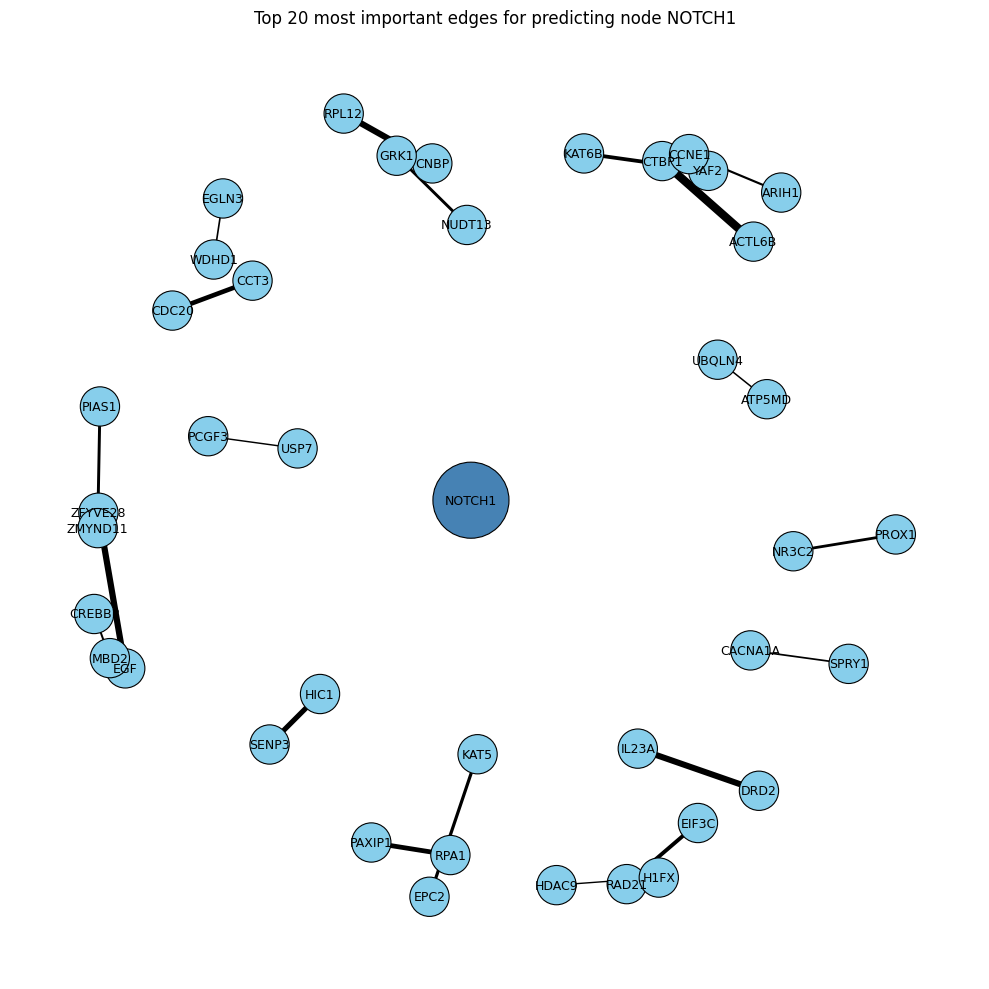

In [11]:
K = 20
# full_edge_mask is a length-E Tensor of sigmoid-normalized scores in [0,1]
# get the indices of the top-K edges
topk = torch.topk(edge_mask, K).indices    # shape [K]
# extract their edge endpoints
topk_edges = graph.edge_index[:, topk]               # shape [2, K]

G = nx.Graph()
# add only the K edges
for u, v in topk_edges.t().tolist():
    G.add_edge(int(u), int(v))

pos = nx.spring_layout(G, seed=42, k=0.5) 
idx2gene = { i: name for i, name in enumerate(graph.name) }

# -----------------------------------------------------------
# 1) make sure the *explained* node is present in the sub-graph
# -----------------------------------------------------------
if node_idx not in G:
    G.add_node(node_idx)            # add it (isolated) so we can style it
    pos[node_idx] = (0, 0)          # optional: anchor it roughly in the centre

# -----------------------------------------------------------
# 2) build style vectors
# -----------------------------------------------------------
# node sizes / colours
node_sizes  = [3000 if n == node_idx else 800      for n in G.nodes()]
node_colors = ['steelblue' if n == node_idx else 'skyblue' for n in G.nodes()]

# edge widths   (→ contribution weight)
edge_scores = edge_mask[topk].cpu().numpy()
# put them on a convenient 1-to-6 pt scale
edge_widths = 1 + 5 * (edge_scores - edge_scores.min()) / (
                          edge_scores.max() - edge_scores.min() + 1e-9)

# build a lookup so the order of widths matches nx.draw_networkx_edges
edge_w_lookup = {(u, v): w for (u, v), w in zip(topk_edges.t().tolist(),
                                                edge_widths)}
edge_widths_ordered = [edge_w_lookup.get((u, v),
                         edge_w_lookup.get((v, u), 1)) for u, v in G.edges()]

# -----------------------------------------------------------
# 3) draw
# -----------------------------------------------------------
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       linewidths=0.8,
                       edgecolors='black')

nx.draw_networkx_edges(G, pos,
                       width=edge_widths_ordered,
                       edge_color='black')

nx.draw_networkx_labels(G, pos,
                       labels={n: idx2gene[n] for n in G.nodes()},
                       font_size=9)

plt.title(f"Top {K} most important edges for predicting node {idx2gene[node_idx]}")
plt.axis('off')
plt.tight_layout()
plt.savefig(f"../paper/figures/top_{K}_edges_{idx2gene[node_idx]}.png",
            dpi=300, bbox_inches='tight')
plt.show()

In [12]:
feature_names = ['MF: KIRC', 'MF: BRCA', 'MF: READ', 'MF: PRAD', 'MF: STAD',
       'MF: HNSC', 'MF: LUAD', 'MF: THCA', 'MF: BLCA', 'MF: ESCA',
       'MF: LIHC', 'MF: UCEC', 'MF: COAD', 'MF: LUSC', 'MF: CESC',
       'MF: KIRP', 'METH: KIRC', 'METH: BRCA', 'METH: READ',
       'METH: PRAD', 'METH: STAD', 'METH: HNSC', 'METH: LUAD',
       'METH: THCA', 'METH: BLCA', 'METH: ESCA', 'METH: LIHC',
       'METH: UCEC', 'METH: COAD', 'METH: LUSC', 'METH: CESC',
       'METH: KIRP', 'GE: KIRC', 'GE: BRCA', 'GE: READ', 'GE: PRAD',
       'GE: STAD', 'GE: HNSC', 'GE: LUAD', 'GE: THCA', 'GE: BLCA',
       'GE: ESCA', 'GE: LIHC', 'GE: UCEC', 'GE: COAD', 'GE: LUSC',
       'GE: CESC', 'GE: KIRP', 'CNA: KIRC', 'CNA: BRCA', 'CNA: READ',
       'CNA: PRAD', 'CNA: STAD', 'CNA: HNSC', 'CNA: LUAD',
       'CNA: THCA', 'CNA: BLCA', 'CNA: ESCA', 'CNA: LIHC',
       'CNA: UCEC', 'CNA: COAD', 'CNA: LUSC', 'CNA: CESC',
       'CNA: KIRP']

feat_imp = node_feat_mask.cpu().numpy()
feat_imp = np.squeeze(feat_imp)                     # now shape (F,)

# 2) Sanity check lengths:
assert feat_imp.shape[0] == len(feature_names), (
    f"mask length {feat_imp.shape[0]} vs names {len(feature_names)}"
)

df = pd.DataFrame({
    'feature': feature_names,   # e.g. ['expr', 'meth', 'mut', …]
    'importance': feat_imp
}).sort_values('importance', ascending=False)
print(df.head(20))

       feature  importance
4     MF: STAD    0.164261
7     MF: THCA    0.157933
37    GE: HNSC    0.155153
27  METH: UCEC    0.153764
22  METH: LUAD    0.153625
41    GE: ESCA    0.153180
3     MF: PRAD    0.150893
51   CNA: PRAD    0.150682
32    GE: KIRC    0.150160
20  METH: STAD    0.149573
59   CNA: UCEC    0.149388
13    MF: LUSC    0.148943
29  METH: LUSC    0.148132
17  METH: BRCA    0.148007
63   CNA: KIRP    0.147275
9     MF: ESCA    0.146547
46    GE: CESC    0.146487
62   CNA: CESC    0.146404
26  METH: LIHC    0.145880
28  METH: COAD    0.145877


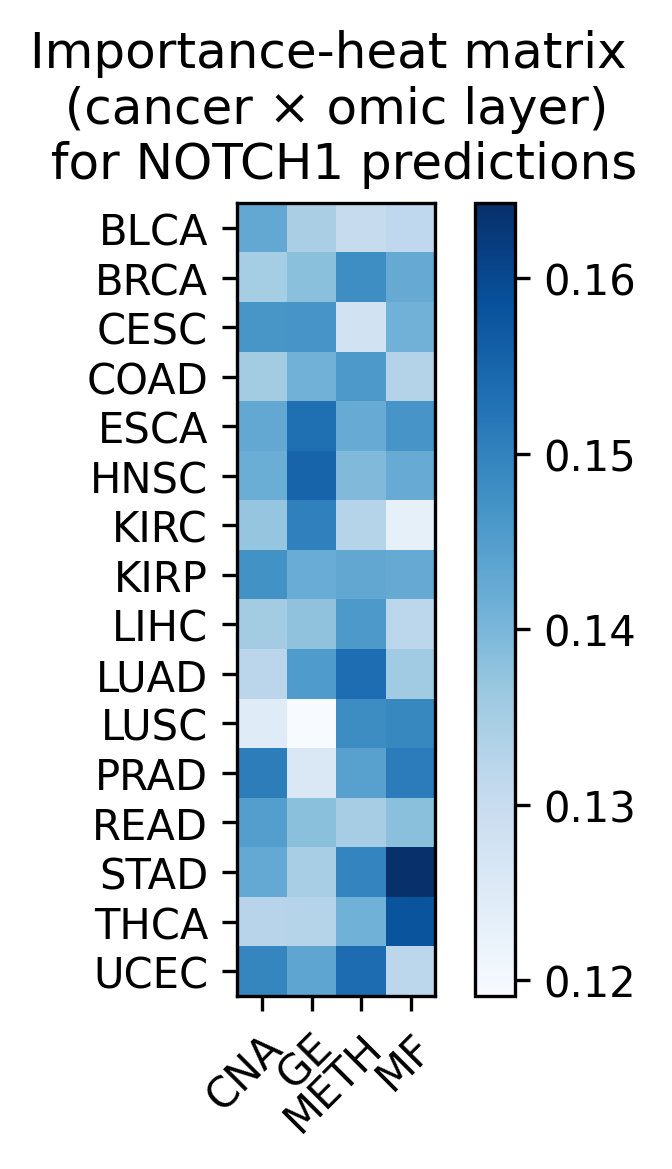

Heat-matrix saved → feature_importance_heatmatrix_NOTCH1.png


In [22]:
TOP_K        = 20                 # how many bars to keep
SAVE_PATH    = "../paper/figures/feature_importance_bar_NOTCH1.png"
DPI          = 300
# Build a wide matrix: rows = cancer type, columns = layer
wide_df = (
    df.assign(
        layer  = df["feature"].str.split(":").str[0].str.strip(),
        cancer = df["feature"].str.split(":").str[1].str.strip()
    )
    .pivot(index="cancer", columns="layer", values="importance")
    .fillna(0)
)

fig2, ax2 = plt.subplots(figsize=(4, 4), dpi=DPI)
im = ax2.imshow(wide_df.values,
                cmap="Blues",
                vmin=df["importance"].min(),
                vmax=df["importance"].max())

ax2.set_xticks(range(len(wide_df.columns)))
ax2.set_yticks(range(len(wide_df.index)))
ax2.set_xticklabels(wide_df.columns)
ax2.set_yticklabels(wide_df.index)

plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize = 10)
ax2.set_title("Importance-heat matrix \n (cancer × omic layer) \n for NOTCH1 predictions",  fontsize = 12)
fig2.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
fig2.tight_layout()
fig2.savefig("../paper/figures/feature_importance_heatmatrix_NOTCH1.png", dpi=DPI, bbox_inches="tight")
plt.show()
print("Heat-matrix saved → feature_importance_heatmatrix_NOTCH1.png")

### **LAMA3**

In [27]:
graph.name[10660]

# ----------------------
# Explanation with GNNExplainer (using the classification head)
# ----------------------
node_idx = 10660 

# Wrap model with modified GNNExplainer
explainer = GNNExplainer(encoder, epochs=200, lr=0.01, num_hops=2)

# Get explanation masks
node_feat_mask, edge_mask = explainer.explain_node(node_idx, graph)

x_sub shape: torch.Size([1190, 64])
edge_index_sub shape: torch.Size([2, 55652])
mapping: tensor([1007])
Out 1: tensor([[-0.0446],
        [-0.0493],
        [-0.0444],
        ...,
        [-0.0461],
        [-0.0449],
        [-0.0490]])
Out after extraction: tensor([[-0.0446],
        [-0.0493],
        [-0.0444],
        ...,
        [-0.0461],
        [-0.0449],
        [-0.0490]])
log_logits shape: torch.Size([1190, 1])
pred_label shape: torch.Size([1190])
Module is Instance of MessagePassing
Module is Instance of MessagePassing
Module is Instance of MessagePassing


Explain node 10660: 100%|██████████| 200/200 [00:04<00:00, 44.94it/s]


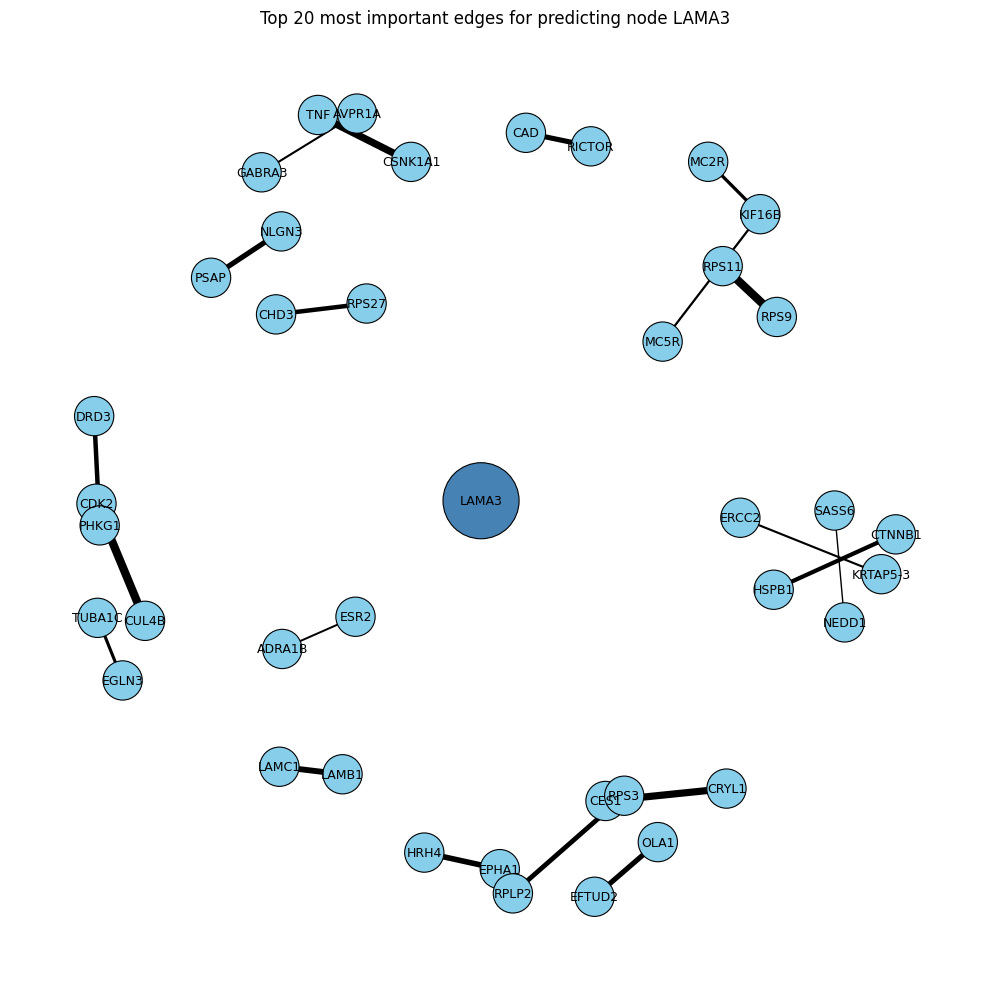

In [28]:
K = 20
# full_edge_mask is a length-E Tensor of sigmoid-normalized scores in [0,1]
# get the indices of the top-K edges
topk = torch.topk(edge_mask, K).indices    # shape [K]
# extract their edge endpoints
topk_edges = graph.edge_index[:, topk]               # shape [2, K]

G = nx.Graph()
# add only the K edges
for u, v in topk_edges.t().tolist():
    G.add_edge(int(u), int(v))

pos = nx.spring_layout(G, seed=42, k=0.5) 
idx2gene = { i: name for i, name in enumerate(graph.name) }

# -----------------------------------------------------------
# 1) make sure the *explained* node is present in the sub-graph
# -----------------------------------------------------------
if node_idx not in G:
    G.add_node(node_idx)            # add it (isolated) so we can style it
    pos[node_idx] = (0, 0)          # optional: anchor it roughly in the centre

# -----------------------------------------------------------
# 2) build style vectors
# -----------------------------------------------------------
# node sizes / colours
node_sizes  = [3000 if n == node_idx else 800      for n in G.nodes()]
node_colors = ['steelblue' if n == node_idx else 'skyblue' for n in G.nodes()]

# edge widths   (→ contribution weight)
edge_scores = edge_mask[topk].cpu().numpy()
# put them on a convenient 1-to-6 pt scale
edge_widths = 1 + 5 * (edge_scores - edge_scores.min()) / (
                          edge_scores.max() - edge_scores.min() + 1e-9)

# build a lookup so the order of widths matches nx.draw_networkx_edges
edge_w_lookup = {(u, v): w for (u, v), w in zip(topk_edges.t().tolist(),
                                                edge_widths)}
edge_widths_ordered = [edge_w_lookup.get((u, v),
                         edge_w_lookup.get((v, u), 1)) for u, v in G.edges()]

# -----------------------------------------------------------
# 3) draw
# -----------------------------------------------------------
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       linewidths=0.8,
                       edgecolors='black')

nx.draw_networkx_edges(G, pos,
                       width=edge_widths_ordered,
                       edge_color='black')

nx.draw_networkx_labels(G, pos,
                       labels={n: idx2gene[n] for n in G.nodes()},
                       font_size=9)

plt.title(f"Top {K} most important edges for predicting node {idx2gene[node_idx]}")
plt.axis('off')
plt.tight_layout()
plt.savefig(f"../paper/figures/top_{K}_edges_{idx2gene[node_idx]}.png",
            dpi=300, bbox_inches='tight')
plt.show()

In [29]:
feature_names = ['MF: KIRC', 'MF: BRCA', 'MF: READ', 'MF: PRAD', 'MF: STAD',
       'MF: HNSC', 'MF: LUAD', 'MF: THCA', 'MF: BLCA', 'MF: ESCA',
       'MF: LIHC', 'MF: UCEC', 'MF: COAD', 'MF: LUSC', 'MF: CESC',
       'MF: KIRP', 'METH: KIRC', 'METH: BRCA', 'METH: READ',
       'METH: PRAD', 'METH: STAD', 'METH: HNSC', 'METH: LUAD',
       'METH: THCA', 'METH: BLCA', 'METH: ESCA', 'METH: LIHC',
       'METH: UCEC', 'METH: COAD', 'METH: LUSC', 'METH: CESC',
       'METH: KIRP', 'GE: KIRC', 'GE: BRCA', 'GE: READ', 'GE: PRAD',
       'GE: STAD', 'GE: HNSC', 'GE: LUAD', 'GE: THCA', 'GE: BLCA',
       'GE: ESCA', 'GE: LIHC', 'GE: UCEC', 'GE: COAD', 'GE: LUSC',
       'GE: CESC', 'GE: KIRP', 'CNA: KIRC', 'CNA: BRCA', 'CNA: READ',
       'CNA: PRAD', 'CNA: STAD', 'CNA: HNSC', 'CNA: LUAD',
       'CNA: THCA', 'CNA: BLCA', 'CNA: ESCA', 'CNA: LIHC',
       'CNA: UCEC', 'CNA: COAD', 'CNA: LUSC', 'CNA: CESC',
       'CNA: KIRP']

feat_imp = node_feat_mask.cpu().numpy()
feat_imp = np.squeeze(feat_imp)                     # now shape (F,)

# 2) Sanity check lengths:
assert feat_imp.shape[0] == len(feature_names), (
    f"mask length {feat_imp.shape[0]} vs names {len(feature_names)}"
)

df = pd.DataFrame({
    'feature': feature_names,   # e.g. ['expr', 'meth', 'mut', …]
    'importance': feat_imp
}).sort_values('importance', ascending=False)
print(df.head(20))

       feature  importance
34    GE: READ    0.167915
52   CNA: STAD    0.158458
1     MF: BRCA    0.155988
28  METH: COAD    0.155360
16  METH: KIRC    0.155123
31  METH: KIRP    0.154416
9     MF: ESCA    0.154374
11    MF: UCEC    0.152543
0     MF: KIRC    0.151363
56   CNA: BLCA    0.151141
12    MF: COAD    0.150673
62   CNA: CESC    0.150511
14    MF: CESC    0.150285
48   CNA: KIRC    0.150243
5     MF: HNSC    0.148820
4     MF: STAD    0.148727
38    GE: LUAD    0.148633
20  METH: STAD    0.147231
37    GE: HNSC    0.147220
41    GE: ESCA    0.147182


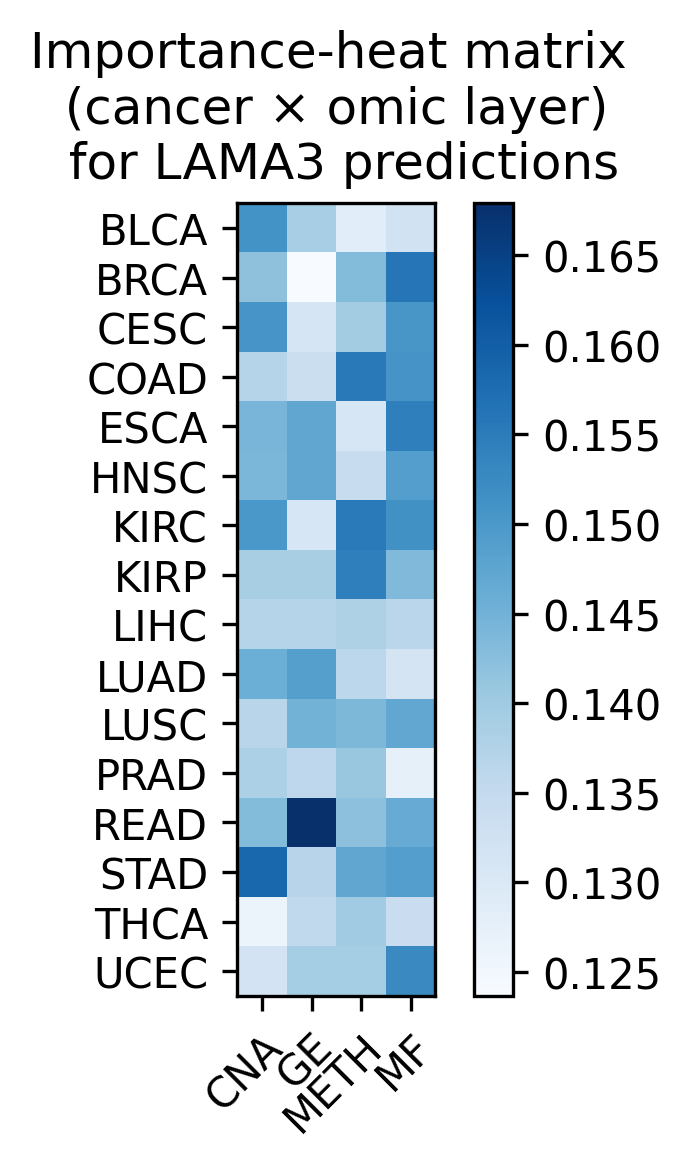

Heat-matrix saved → feature_importance_heatmatrix_LAMA3.png


In [30]:
TOP_K        = 20                 # how many bars to keep
DPI          = 300
# Build a wide matrix: rows = cancer type, columns = layer
wide_df = (
    df.assign(
        layer  = df["feature"].str.split(":").str[0].str.strip(),
        cancer = df["feature"].str.split(":").str[1].str.strip()
    )
    .pivot(index="cancer", columns="layer", values="importance")
    .fillna(0)
)

fig2, ax2 = plt.subplots(figsize=(4, 4), dpi=DPI)
im = ax2.imshow(wide_df.values,
                cmap="Blues",
                vmin=df["importance"].min(),
                vmax=df["importance"].max())

ax2.set_xticks(range(len(wide_df.columns)))
ax2.set_yticks(range(len(wide_df.index)))
ax2.set_xticklabels(wide_df.columns)
ax2.set_yticklabels(wide_df.index)

plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize = 10)
ax2.set_title(f"Importance-heat matrix \n (cancer × omic layer) \n for {idx2gene[node_idx]} predictions",  fontsize = 12)
fig2.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
fig2.tight_layout()
fig2.savefig(f"../paper/figures/feature_importance_heatmatrix_{idx2gene[node_idx]}.png", dpi=DPI, bbox_inches="tight")
plt.show()
print(f"Heat-matrix saved → feature_importance_heatmatrix_{idx2gene[node_idx]}.png")

### **IL4R**

In [32]:
print(graph.name[740])
# ----------------------
# Explanation with GNNExplainer (using the classification head)
# ----------------------
node_idx = 740 

# Wrap model with modified GNNExplainer
explainer = GNNExplainer(encoder, epochs=200, lr=0.01, num_hops=2)

# Get explanation masks
node_feat_mask, edge_mask = explainer.explain_node(node_idx, graph)

IL4R
x_sub shape: torch.Size([1665, 64])
edge_index_sub shape: torch.Size([2, 92836])
mapping: tensor([222])
Out 1: tensor([[-0.0445],
        [-0.0473],
        [-0.0443],
        ...,
        [-0.0445],
        [-0.0445],
        [-0.0466]])
Out after extraction: tensor([[-0.0445],
        [-0.0473],
        [-0.0443],
        ...,
        [-0.0445],
        [-0.0445],
        [-0.0466]])
log_logits shape: torch.Size([1665, 1])
pred_label shape: torch.Size([1665])
Module is Instance of MessagePassing
Module is Instance of MessagePassing
Module is Instance of MessagePassing


Explain node 740: 100%|██████████| 200/200 [00:07<00:00, 26.20it/s]


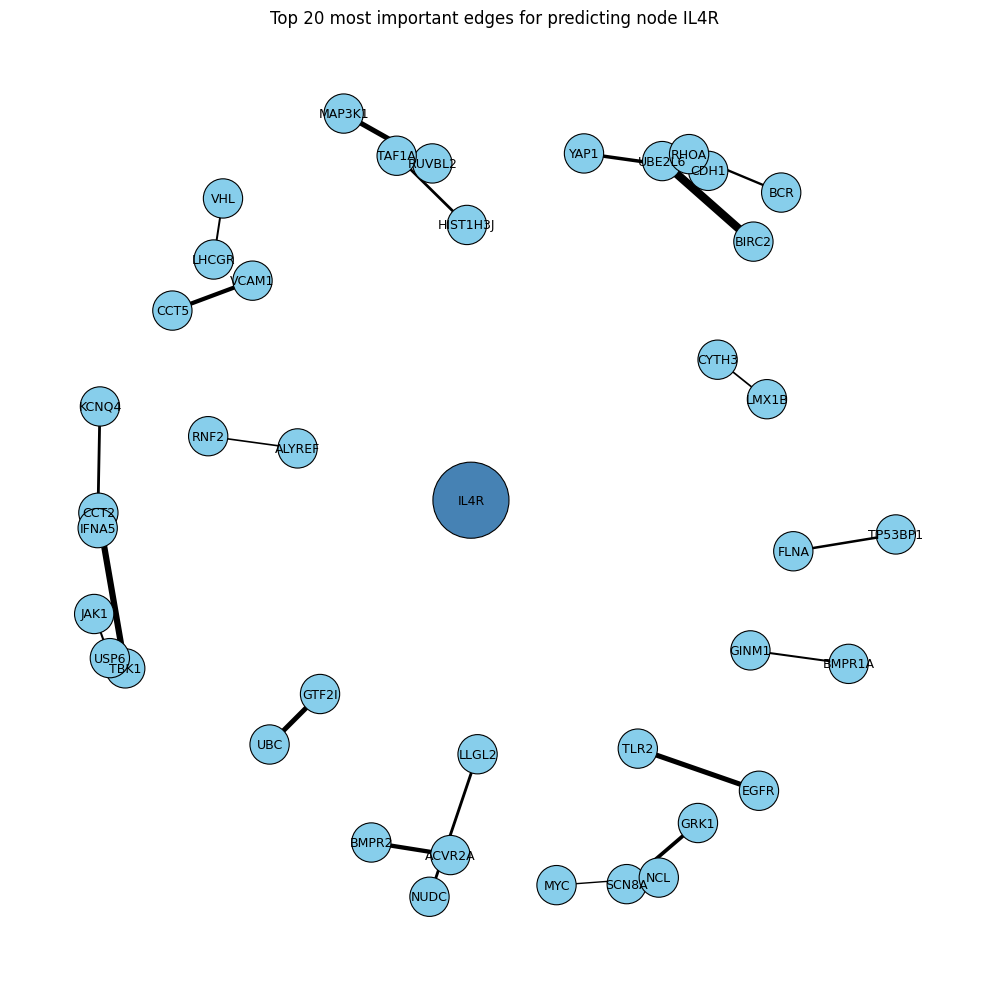

In [33]:
K = 20
# full_edge_mask is a length-E Tensor of sigmoid-normalized scores in [0,1]
# get the indices of the top-K edges
topk = torch.topk(edge_mask, K).indices    # shape [K]
# extract their edge endpoints
topk_edges = graph.edge_index[:, topk]               # shape [2, K]

G = nx.Graph()
# add only the K edges
for u, v in topk_edges.t().tolist():
    G.add_edge(int(u), int(v))

pos = nx.spring_layout(G, seed=42, k=0.5) 
idx2gene = { i: name for i, name in enumerate(graph.name) }

# -----------------------------------------------------------
# 1) make sure the *explained* node is present in the sub-graph
# -----------------------------------------------------------
if node_idx not in G:
    G.add_node(node_idx)            # add it (isolated) so we can style it
    pos[node_idx] = (0, 0)          # optional: anchor it roughly in the centre

# -----------------------------------------------------------
# 2) build style vectors
# -----------------------------------------------------------
# node sizes / colours
node_sizes  = [3000 if n == node_idx else 800      for n in G.nodes()]
node_colors = ['steelblue' if n == node_idx else 'skyblue' for n in G.nodes()]

# edge widths   (→ contribution weight)
edge_scores = edge_mask[topk].cpu().numpy()
# put them on a convenient 1-to-6 pt scale
edge_widths = 1 + 5 * (edge_scores - edge_scores.min()) / (
                          edge_scores.max() - edge_scores.min() + 1e-9)

# build a lookup so the order of widths matches nx.draw_networkx_edges
edge_w_lookup = {(u, v): w for (u, v), w in zip(topk_edges.t().tolist(),
                                                edge_widths)}
edge_widths_ordered = [edge_w_lookup.get((u, v),
                         edge_w_lookup.get((v, u), 1)) for u, v in G.edges()]

# -----------------------------------------------------------
# 3) draw
# -----------------------------------------------------------
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       linewidths=0.8,
                       edgecolors='black')

nx.draw_networkx_edges(G, pos,
                       width=edge_widths_ordered,
                       edge_color='black')

nx.draw_networkx_labels(G, pos,
                       labels={n: idx2gene[n] for n in G.nodes()},
                       font_size=9)

plt.title(f"Top {K} most important edges for predicting node {idx2gene[node_idx]}")
plt.axis('off')
plt.tight_layout()
plt.savefig(f"../paper/figures/top_{K}_edges_{idx2gene[node_idx]}.png",
            dpi=300, bbox_inches='tight')
plt.show()

In [34]:
feature_names = ['MF: KIRC', 'MF: BRCA', 'MF: READ', 'MF: PRAD', 'MF: STAD',
       'MF: HNSC', 'MF: LUAD', 'MF: THCA', 'MF: BLCA', 'MF: ESCA',
       'MF: LIHC', 'MF: UCEC', 'MF: COAD', 'MF: LUSC', 'MF: CESC',
       'MF: KIRP', 'METH: KIRC', 'METH: BRCA', 'METH: READ',
       'METH: PRAD', 'METH: STAD', 'METH: HNSC', 'METH: LUAD',
       'METH: THCA', 'METH: BLCA', 'METH: ESCA', 'METH: LIHC',
       'METH: UCEC', 'METH: COAD', 'METH: LUSC', 'METH: CESC',
       'METH: KIRP', 'GE: KIRC', 'GE: BRCA', 'GE: READ', 'GE: PRAD',
       'GE: STAD', 'GE: HNSC', 'GE: LUAD', 'GE: THCA', 'GE: BLCA',
       'GE: ESCA', 'GE: LIHC', 'GE: UCEC', 'GE: COAD', 'GE: LUSC',
       'GE: CESC', 'GE: KIRP', 'CNA: KIRC', 'CNA: BRCA', 'CNA: READ',
       'CNA: PRAD', 'CNA: STAD', 'CNA: HNSC', 'CNA: LUAD',
       'CNA: THCA', 'CNA: BLCA', 'CNA: ESCA', 'CNA: LIHC',
       'CNA: UCEC', 'CNA: COAD', 'CNA: LUSC', 'CNA: CESC',
       'CNA: KIRP']

feat_imp = node_feat_mask.cpu().numpy()
feat_imp = np.squeeze(feat_imp)                     # now shape (F,)

# 2) Sanity check lengths:
assert feat_imp.shape[0] == len(feature_names), (
    f"mask length {feat_imp.shape[0]} vs names {len(feature_names)}"
)

df = pd.DataFrame({
    'feature': feature_names,   # e.g. ['expr', 'meth', 'mut', …]
    'importance': feat_imp
}).sort_values('importance', ascending=False)
print(df.head(20))

       feature  importance
5     MF: HNSC    0.164555
16  METH: KIRC    0.162970
50   CNA: READ    0.155238
61   CNA: LUSC    0.154811
7     MF: THCA    0.153818
33    GE: BRCA    0.152696
17  METH: BRCA    0.150985
42    GE: LIHC    0.150693
58   CNA: LIHC    0.150528
62   CNA: CESC    0.149353
14    MF: CESC    0.149131
39    GE: THCA    0.149127
51   CNA: PRAD    0.149052
19  METH: PRAD    0.148385
37    GE: HNSC    0.147454
60   CNA: COAD    0.147392
48   CNA: KIRC    0.146822
2     MF: READ    0.146069
43    GE: UCEC    0.145642
40    GE: BLCA    0.145574


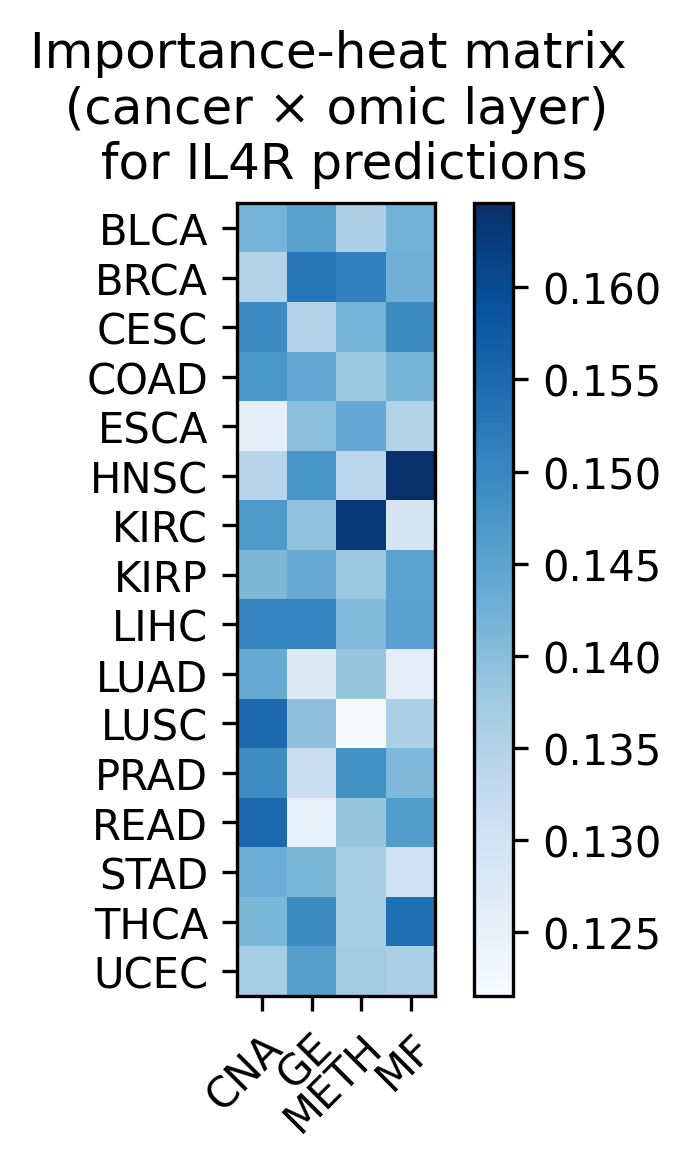

Heat-matrix saved → feature_importance_heatmatrix_IL4R.png


In [35]:
TOP_K        = 20                 # how many bars to keep
DPI          = 300
# Build a wide matrix: rows = cancer type, columns = layer
wide_df = (
    df.assign(
        layer  = df["feature"].str.split(":").str[0].str.strip(),
        cancer = df["feature"].str.split(":").str[1].str.strip()
    )
    .pivot(index="cancer", columns="layer", values="importance")
    .fillna(0)
)

fig2, ax2 = plt.subplots(figsize=(4, 4), dpi=DPI)
im = ax2.imshow(wide_df.values,
                cmap="Blues",
                vmin=df["importance"].min(),
                vmax=df["importance"].max())

ax2.set_xticks(range(len(wide_df.columns)))
ax2.set_yticks(range(len(wide_df.index)))
ax2.set_xticklabels(wide_df.columns)
ax2.set_yticklabels(wide_df.index)

plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize = 10)
ax2.set_title(f"Importance-heat matrix \n (cancer × omic layer) \n for {idx2gene[node_idx]} predictions",  fontsize = 12)
fig2.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
fig2.tight_layout()
fig2.savefig(f"../paper/figures/feature_importance_heatmatrix_{idx2gene[node_idx]}.png", dpi=DPI, bbox_inches="tight")
plt.show()
print(f"Heat-matrix saved → feature_importance_heatmatrix_{idx2gene[node_idx]}.png")